In [1]:
import os
import random
import itertools
import re

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# データセット分割
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    ShuffleSplit,
    StratifiedShuffleSplit,
    KFold,
)

# 特徴量選択
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy

# https://github.com/smazzanti/mrmr
# pipでinstallはできたが、そのままimportできなかったので、
# ライブラリのソースコードをそのまま環境に設置
from libraries.mrmr import mrmr

# 学習中
from tqdm import tqdm
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings

import networkx as nx


# config python file
import config

SEED = config.SEED
INDEX_MICROARRAY = config.INDEX_MICROARRAY

from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# データ読み込み


## 生データの読み込み

In [2]:
df_patient = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_patient.txt", header=4
)
df_sample = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_sample.txt", header=4
)

In [3]:
df_clinical = pd.merge(df_patient, df_sample, on="PATIENT_ID")

## カラムの順序変更（読みやすさのため）

In [4]:
def align_columns(df: pd.DataFrame, regex: str):
    # まとめたいcolumnの正規表現を一時退避
    df_copy = df.copy()
    df_tmp = df_copy.filter(regex=regex)
    # 元のdfから落とす
    df_copy.drop(df_tmp.columns, axis=1, inplace=True)
    # 元のdfに結合
    return pd.merge(df_copy, df_tmp, right_index=True, left_index=True)

In [5]:
# 癌の種類
df_clinical = align_columns(df_clinical, "^CANCER_")
# 重要そう（直感）な特徴量
df_clinical = align_columns(df_clinical, "^ER_|^HER2_|^TUMOR_")
# 治療の種類
df_clinical = align_columns(df_clinical, ".*THERAPY$|^BREAST_SURGERY")
# target系の種類（OS, RFS, VITAL）
df_clinical = align_columns(df_clinical, "^OS_.*|^RFS_.*|^VITAL_.*")

In [6]:
# データを大きく2つに分割できるので、ここで分割
df_MB = df_clinical[df_clinical["PATIENT_ID"].str.contains("MB")]
df_MTST = df_clinical[df_clinical["PATIENT_ID"].str.contains("MTS-T")]
df_MB.shape, df_MTST.shape

# save
make_dir(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR)
df_MB.to_pickle(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/df_MB.pkl")

## 遺伝子データの読み込み

In [7]:
# 遺伝子発現データ
# 生の遺伝子発現データ
df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop(
    "Entrez_Gene_Id"
).sort_index()
# zスコア化済み
df_mrna_agilent_microarray_zscores_ref_all_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_all_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_all_samples = (
    df_mrna_agilent_microarray_zscores_ref_all_samples.drop("Entrez_Gene_Id")
).sort_index()
# zスコア化（2倍体基準）済み
df_mrna_agilent_microarray_zscores_ref_diploid_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_diploid_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_diploid_samples = (
    df_mrna_agilent_microarray_zscores_ref_diploid_samples.drop("Entrez_Gene_Id")
).sort_index()


# important to decide X_dict name
SET_DF_MICROARRAY = (
    df_mrna_agilent_microarray,
    df_mrna_agilent_microarray_zscores_ref_all_samples,
    df_mrna_agilent_microarray_zscores_ref_diploid_samples,
)

# 目的変数の生成

元のdfにはない目的変数カラム（5年後の生存の有無）を生成する。

## 目的変数｜5,10,15年後の予後の2値分類
5,10,15年後の予後を2値分類する。  
そのためにVITAL_STATUSとOS_MONTHを利用する。  
以下のフローチャートで生成する。  

In [8]:
HTML(
    '<div class="mxgraph" style="max-width:100%;border:1px solid transparent;" data-mxgraph="{&quot;highlight&quot;:&quot;#0000ff&quot;,&quot;nav&quot;:true,&quot;resize&quot;:true,&quot;toolbar&quot;:&quot;zoom layers tags lightbox&quot;,&quot;edit&quot;:&quot;_blank&quot;,&quot;xml&quot;:&quot;&lt;mxfile host=\&quot;Electron\&quot; modified=\&quot;2022-05-01T07:33:42.0.405Z\&quot; agent=\&quot;5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) draw.io/17.2.0.2 Chrome/100.0.4896.60 Electron/18.0.1 Safari/537.36\&quot; etag=\&quot;CUa6MuG2A-EYqdbBh0ys\&quot; version=\&quot;17.2.0.2\&quot; type=\&quot;device\&quot;&gt;&lt;diagram id=\&quot;C5RBs43oDa-KdzZeNtuy\&quot; name=\&quot;Page-1\&quot;&gt;7VhZc5swEP41TJ7a4Yix/RjbcZI2SduBJNOnjAIyqBasK4SP/vpKQTIQXB9tncMTP3jYZVlJ+317gOH0k/kZQ5P4CkJMDdsM54YzMGy7ZZniXyoWhcLtOoUiYiQsVFap8MgvrJTquSgnIc5qhhyAcjKpKwNIUxzwmg4xBrO62QhofdUJinBD4QWINrV3JORxoe3Y7VJ/jkkU65Utt1vcSZA2VifJYhTCrKJyTg2nzwB4cZXM+5jK2Om43F0s7ujl2D379C37iW56n/3r2w+Fs+EujyyPwHDK/69ru3A9RTRX8VJn5QsdQAZ5GmLpxDScXswTKi4tcfkDc75QgKOcg1AB4zFEkCJ6CTBRdiNIuTKzpIzT8EQCK+QHCsG4UA0JpWoNISn7jpAyzmC8xE46WAIhjSl6wLSHgnH0uNE+UGDiVgoplq5CQQZ1lnJzp6W2t2VsFQYZ5CzAa+xUcnDEIrzOn1vYyf1VeKqQO8OQYM4WwoBhijiZ1smMVE5ES7sSd3GhoN+BBk6DBuHIaPVuL/yTy3vPP/FvPMMWrs0v3v3Vl2v/3DNagzVMkSjNYsKxN0GP4ZqJ2lJnT5UV4uC9iKIsU5hugHw3yKaYcTxfG2R911WZrkpdR4mzsm5YuhjElZpxbO4JluMGLN9FKX1P0H9JUHfLBNX9a2OGKrJoYmydsMrTVyDiXKUJjEaZ2NhT6iwX/Hs2tRpsuoYGmTbj8abp9kJkau/GJevVc8ltcKnsDDITXJTIek+5jLm8b+raWi1cMSQPeba5V9QAlvQZooRQGaxzTKeYkwCt6CiIkigVQiCwxmw1c8SSJI2E5JaS/8hUUXz32Gna9U6zlKutxlzRajr7ajXt1ROAYrZs9maB4xDRDB9c63fsJ4B0X7r3d7ap1m+6Fj9769dldXPvt7as14o95kdH/GoEev3jQHer4fJ9HtgPw+xDmwj0Dit8qr8+qv5xNCCCLLYJI/E3IBlGGT56Hw3+OBrYqzrRs44GuhpWZwMmAnFoM8DT1/9j56VnAF0lNk9lPssPfyhzrP0BIsTyS25RE8vP4c7pbw==&lt;/diagram&gt;&lt;/mxfile&gt;&quot;}"></div><script type="text/javascript" src="https://viewer.diagrams.net/js/viewer-static.min.js"></script>'
)

In [9]:
def make_target(df: pd.DataFrame(), year: int = 5, drop=False):
    df = df.copy()  # 引数dfの更新を防ぐ（pythonの関数は参照渡し）
    target_name = "OS_{0}years".format(str(year).zfill(2))
    df[target_name] = np.nan
    df[target_name] = df[target_name].mask(df["OS_MONTHS"] > year * 12, False)
    df[target_name] = df[target_name].mask(
        (df["OS_MONTHS"] <= year * 12) & (df["VITAL_STATUS"] == "Died of Disease"),
        True,
    )
    # targetを定義できなかったデータは除く
    if drop:
        df = df[df[target_name].notnull()]
    return df

In [10]:
df_MB = make_target(df_MB, year=5)
df_MB = make_target(df_MB, year=10)
df_MB = make_target(df_MB, year=15)
target_list = ["OS_05years", "OS_10years", "OS_15years"]

# データフレームの結合

臨床データと遺伝子データを結合する  
結合パターン
1. 臨床データと生の遺伝子発現データ
2. 臨床データとzスコア化した遺伝子発現データ
3. 臨床データとzスコア化（2倍体）した遺伝子発現データ


## データフレームの結合
### 使用する特徴量

臨床データ
- 目的変数：OS_nyears
- 遺伝子学的特徴量：CLAUDIN_SUBTYPE
- その他重要そうな特徴量：NPI（3.0.0のSHAPで重要度高）、ER_STATUS, HER2_STATUS, PR_STATUS（ドメイン知識）

遺伝子発現データ
- 全ての遺伝子発現

In [11]:
df_MB.columns

Index(['PATIENT_ID', 'LYMPH_NODES_EXAMINED_POSITIVE', 'NPI', 'CELLULARITY',
       'COHORT', 'INFERRED_MENOPAUSAL_STATE', 'SEX', 'INTCLUST',
       'AGE_AT_DIAGNOSIS', 'CLAUDIN_SUBTYPE', 'THREEGENE', 'LATERALITY',
       'HISTOLOGICAL_SUBTYPE', 'SAMPLE_ID', 'GRADE', 'ONCOTREE_CODE',
       'PR_STATUS', 'SAMPLE_TYPE', 'TMB_NONSYNONYMOUS', 'CANCER_TYPE',
       'CANCER_TYPE_DETAILED', 'ER_IHC', 'HER2_SNP6', 'ER_STATUS',
       'HER2_STATUS', 'TUMOR_SIZE', 'TUMOR_STAGE', 'CHEMOTHERAPY',
       'HORMONE_THERAPY', 'RADIO_THERAPY', 'BREAST_SURGERY', 'OS_MONTHS',
       'OS_STATUS', 'VITAL_STATUS', 'RFS_STATUS', 'RFS_MONTHS', 'OS_05years',
       'OS_10years', 'OS_15years'],
      dtype='object')

In [12]:
# 結合する臨床データ
patient_columns = [
    "PATIENT_ID",
    "OS_05years",
    "OS_10years",
    "OS_15years",
    "CLAUDIN_SUBTYPE",
    # "NPI",
    # "ER_STATUS",
    # "HER2_STATUS",
    # "PR_STATUS",
    # "LYMPH_NODES_EXAMINED_POSITIVE",
    # "COHORT",
    # "TUMOR_SIZE",
]

In [13]:
# 臨床データ特徴量の欠損値の削除
df_tmp = df_MB[
    df_MB[
        [
            "CLAUDIN_SUBTYPE",
            # "NPI",
            # "ER_STATUS",
            # "HER2_STATUS",
            # "PR_STATUS",
            # "LYMPH_NODES_EXAMINED_POSITIVE",
            # "COHORT",
            # "TUMOR_SIZE",
        ]
    ]
    .notnull()
    .all(axis=1)
][patient_columns].replace({"Positive": 1, "Negative": 0})
print("臨床データサイズ：", df_tmp.shape)

df_cross = pd.merge(
    df_tmp,
    # df_mrna_agilent_microarray,
    SET_DF_MICROARRAY[INDEX_MICROARRAY],
    # df_mrna_agilent_microarray_zscores_ref_diploid_samples
    left_on="PATIENT_ID",
    right_index=True,
    how="right",
).reset_index(drop=True)
print(df_cross.shape)

臨床データサイズ： (1980, 5)
(1904, 24373)


 ### 重複カラムのリネーム
有識者の意見：重複した遺伝子発現は別の遺伝子発現として扱うべき。


In [14]:
# 重複特徴量の確認
print("重複特徴量")
print(df_cross.columns[df_cross.columns.duplicated()].value_counts())
# 重複特徴量のrename
df_cross = rename_duplicated_columns(df_cross)
# 重複特徴量の確認
print("重複特徴量（rename後確認）")
print(df_cross.columns[df_cross.columns.duplicated()].value_counts())

重複特徴量
TRDV2        6
RPL13A       5
IL23A        4
WASH3P       3
LINC00965    2
            ..
CLK2         1
TNRC18       1
KPNA2        1
RPL4         1
C4orf50      1
Length: 170, dtype: int64
重複特徴量（rename後確認）
Series([], dtype: int64)


# 欠損値データの処理

### OS_05yearsが欠損しているデータの削除

In [15]:
df_cross = df_cross[df_cross["OS_05years"].notnull()]
df_cross.shape

(1757, 24373)

### 遺伝子発現の欠損値の確認

<AxesSubplot:>

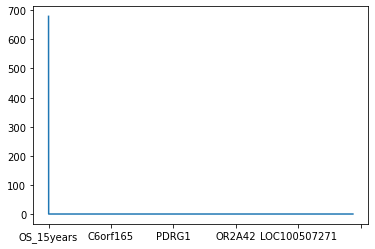

In [16]:
series_genes = df_cross.isnull().sum().sort_values()[::-1]
series_genes.plot()

for some microarray, some gene expressions contains many nan, some gene expressions aontains a few nan

### drop cols including many nans

In [17]:
drop_cols_high = series_genes[
    series_genes.values > 1000
].index  # select genes expression name
df_cross = df_cross.drop(drop_cols_high, axis=1)

### drop rows including many nans

In [18]:
genes_cols = df_cross.columns.tolist()
[genes_cols.remove(i) for i in patient_columns]

[None, None, None, None, None]

In [19]:
series_tmp = df_cross[genes_cols].isnull().sum()
drop_cols_row = series_tmp[series_tmp.values > 0].index

for c in drop_cols_row:
    df_cross = df_cross[df_cross[c].notnull()]
df_cross.shape

(1748, 24373)

# 統計的性質の確認

各遺伝子発現が、統計的手法を適用する前提の性質を兼ねているのかを確認する

## 確認要素
- 特徴量毎の分散
- それぞれの特徴量が独立
- それぞれの特徴量の母集団の分布が正規分布
- それぞれの特徴量の母集団の分布の分散が全て等しい

## 分散の確認

In [20]:
sel = VarianceThreshold(threshold=0.8 * (1 - 0.8))
df_dropped_tmp = df_cross.drop(patient_columns, axis=1)
sel.fit_transform(df_dropped_tmp)


df_tmp = pd.DataFrame(
    sel.fit_transform(df_dropped_tmp),
    columns=df_dropped_tmp.columns.values[sel.get_support()],
)
print(
    "Before Feature Selection:",
    df_dropped_tmp.shape,
)
print("After Feature Selection:", df_tmp.shape)

result = pd.DataFrame(
    sel.get_support(),
    index=df_dropped_tmp.columns.values,
    columns=["False: dropped"],
)
result["variance"] = sel.variances_
display(result.sort_values("variance", ascending=False).head())
display(
    result[result["False: dropped"] == False]
    .sort_values("variance", ascending=False)
    .tail()
)

Before Feature Selection: (1748, 24368)
After Feature Selection: (1748, 24368)


,False: dropped,variance
MAEL,True,1.071089
GPR12,True,1.065328
CR741512,True,1.064612
NOL4,True,1.062551
SEZ6L,True,1.061266


,False: dropped,variance


分散の小さいデータは削除

In [21]:
df_target = df_cross[patient_columns]
df_tmp = df_cross[result[result["False: dropped"] == True].index]
df_cross = pd.merge(df_target, df_tmp, right_index=True, left_index=True)

## 独立性の検定

### カイ2乗検定

H0: 全ての特徴量が独立である  
H1: 全ての特徴量が独立でない

特徴量全てを同時に検定

np_tmp = df_cross.drop(patient_columns, axis=1).values

result = stats.chi2_contingency(np_tmp)

print("期待度数", "\n", result[0])
print("自由度", "\n", result[1])
print("カイ二乗値", "\n", result[2])
print("p値", "\n", result[3])

特徴量2組毎に検定

In [22]:
"""
list_columns = df_cross.drop(patient_columns, axis=1).columns

comb_columns = list(itertools.combinations(list_columns, 2))


for cols in comb_columns:  
    np_tmp = df_cross[cols[0]].values

    result= stats.chi2_contingency(np_tmp)
    if result[3] < 0.05:
        print("期待度数", "\n", result[0])
        print("自由度", "\n", result[1])
        print("カイ二乗値", "\n", result[2])
        print("p値", "\n", result[3])
"""
pass

独立でない特徴量の組み合わせも無いことがわかる
（実行時間が長いので、コメントアウト）

## 母集団が正規分布であることの確認

### QQプロット

青い点が赤い線に沿っているほど、データが正規分布に近いことを、直感的に解釈できる  
図でしか表さないので、遺伝子発現全てに適用するのは困難そう

<function matplotlib.pyplot.show(close=None, block=None)>

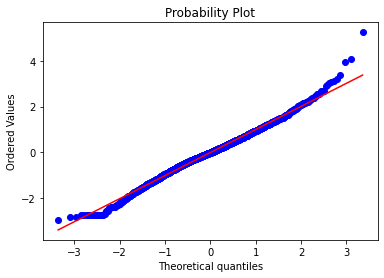

In [23]:
stats.probplot(df_cross[df_cross.columns[-1]], dist="norm", plot=plt)
plt.show

### S-W検定（シャピロ・ウィルク検定）

仮説検定でデータの正規性を確認する手法

少ないデータ（1000データ以下）に対して行われる検定

H0: 正規分布である（標本は正規母集団からサンプリングされたものである）  
H1: 正規分布でない

In [24]:
list_columns = df_cross.drop(patient_columns, axis=1).columns

p = 0.05  # 有意水準1%
dic_sw = dict()
for c in list_columns:
    result = stats.shapiro(df_cross[c])
    if result.pvalue >= p:  # p>=0.05の時、帰無仮説を棄却できず、正規分布とみなす、らしい
        dic_sw[c] = result
        # print(c)
        # plt.hist(df_cross[c], bins=50)
        # plt.title(c)
        # plt.show()
print("num of normal distribution: ", len(dic_sw))

num of normal distribution:  1684


## 母集団の分散が全て等しいことの検定

### バートレット検定

H0:2つの群の分散が等しい  
H1:2つの群の分散は等しくない

全ての遺伝子発現に対し、2個の組み合わせをとっている（nC2）ので、実行時間が長いです

In [25]:
"""# comb_columns = list(itertools.combinations(dic_sw.keys(), 2))
list_columns = df_cross.drop(patient_columns, axis=1).columns
comb_columns = list(itertools.combinations(list_columns, 2))

p = 0.05  # 有意水準5%
dic_bartlett = dict()

# 2つの群（遺伝子発現）を比較する
# forループとitertools.combinationsで、遺伝子発現全ての組み合わせで検定する
for cols in comb_columns:
    np_tmp1 = df_cross[cols[0]].values
    np_tmp2 = df_cross[cols[1]].values
    result = stats.bartlett(np_tmp1, np_tmp2)
    if result.pvalue >= p:  # 帰無仮説を棄却しない▷分散が等しい
        # print("母分散が等しい特徴量の組み合わせ")
        dic_bartlett[cols] = result
"""
pass

全てのノード同士で等分散性が確保されたわけではないようだ

In [26]:
"""

dic_tmp1 = {}
dic_tmp2 = {}
s_tmp1 = set()
s_tmp2 = set()
for i in dic_bartlett.keys():
    if i[0] in dic_tmp1:
        dic_tmp1[i[0]] += 1
    else:
        s_tmp1.add(i[0])
        dic_tmp1[i[0]] = 1

    if i[1] in dic_tmp2:
        dic_tmp2[i[1]] += 1
    else:
        s_tmp2.add(i[1])
        dic_tmp2[i[1]] = 1
print(sorted(dic_tmp1.items(), key=lambda x: x[1])[:10])
print(sorted(dic_tmp2.items(), key=lambda x: x[1])[:10])
len(dic_tmp1), len(dic_tmp2), len(s_tmp1), len(s_tmp2), len(s_tmp1.union(s_tmp2))
"""

pass

ネットワークの可視化（無向グラフ）


In [27]:
"""
s_tmp = s_tmp1.union(s_tmp2)

G = nx.Graph()
G.add_nodes_from(list(s_tmp))
G.add_edges_from(dic_bartlett.keys())

plt.figure(figsize=(30, 30))
nx.draw_networkx(G)
plt.show()
"""
pass

# 遺伝子サブタイプ毎のサンプルの分布の確認

### データセットの分割
trainデータとtestデータに分割  
testデータは訓練には用いない（学習終了後の性能の確認のみ）

trainデータとtestデータを分割した場合の、分布の確認

In [28]:
df_cross.columns

Index(['PATIENT_ID', 'OS_05years', 'OS_10years', 'OS_15years',
       'CLAUDIN_SUBTYPE', 'RERE', 'RNF165', 'CD049690', 'BC033982', 'PHF7',
       ...
       'BX115874', 'BX107598', 'UGCGL1', 'VPS72', 'CSMD3', 'CC2D1A',
       'CB986545', 'IGSF9', 'DA110839', 'FAM71A'],
      dtype='object', length=24373)

In [29]:
df_cross["OS_15years"].value_counts()

True     572
False    501
Name: OS_15years, dtype: int64

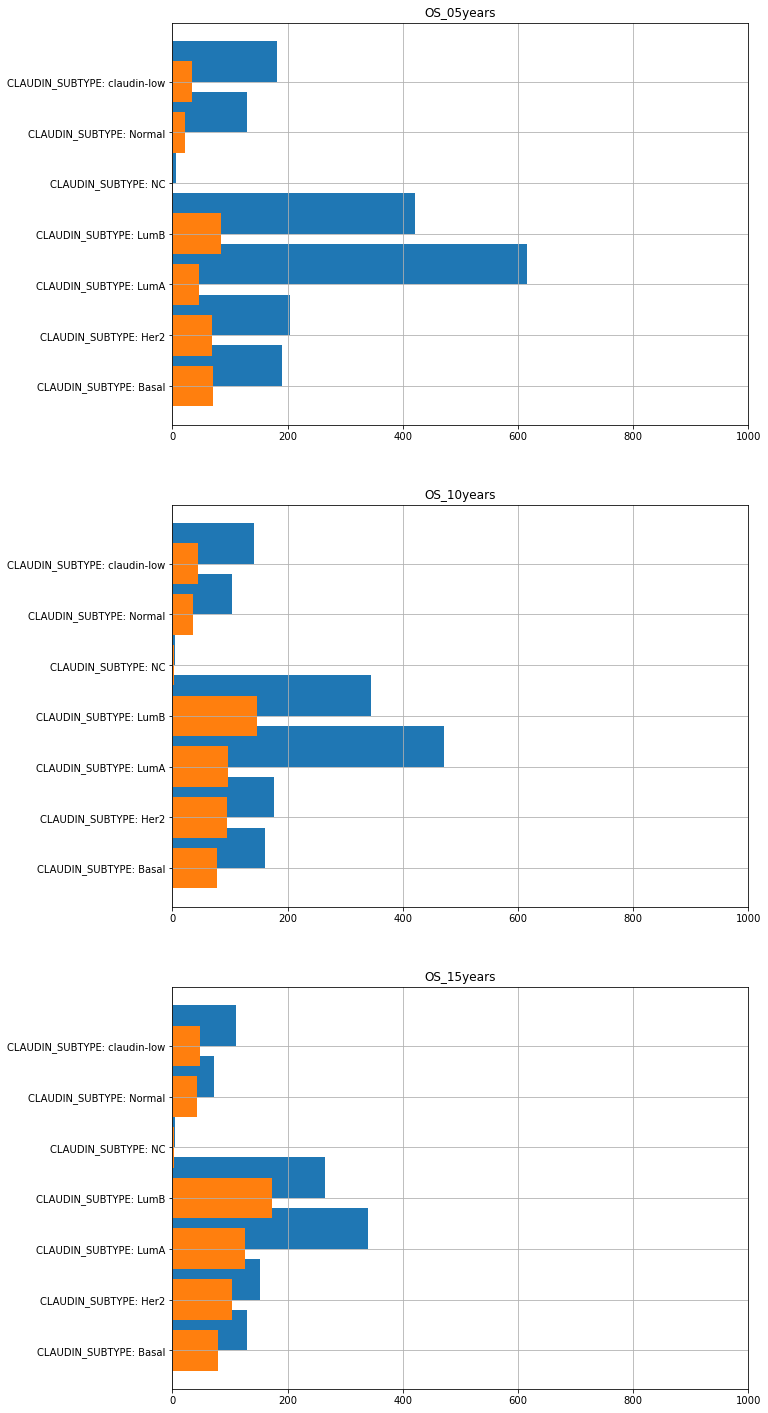

In [30]:
plt.figure(figsize=(20, 34))
plt.subplots_adjust(left=0.5)
funcs = ["count", "sum", "mean"]
for i, v in enumerate(target_list):
    # 各STATUSに属するサンプル数の可視化
    # df_tmp: 表示したい数のdf、df_tmp2: プロット時のクラス名前の付与
    # trai
    df_tmp = df_cross.groupby("CLAUDIN_SUBTYPE")[v].agg(funcs).reset_index()
    df_tmp["gene_label"] = "CLAUDIN_SUBTYPE: " + df_tmp["CLAUDIN_SUBTYPE"]
    plt.subplot(len(target_list) + 1, 1, i + 1)
    plt.barh(y=df_tmp["gene_label"], width=df_tmp["count"], align="edge")

    # 各STAUSに属する目的変数の正例（乳がんによってn年の予後の死亡者数）の可視化
    # sumのカラムを指定しているが、これは目的変数が2値分類であるため、sumがtrueの総数を示している。
    plt.barh(y=df_tmp["gene_label"], width=df_tmp["sum"])
    plt.title(v)
    plt.tight_layout = True
    plt.xlim(0, 1000)

    plt.grid(True)

大まかにはtrain,testのデータ量の比率は大丈夫そう

数の少ないNCについては確認

In [31]:
df_cross[df_cross["CLAUDIN_SUBTYPE"] == "NC"]

,PATIENT_ID,OS_05years,OS_10years,OS_15years,CLAUDIN_SUBTYPE,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,AK055082,BU687559,LIN52,PCOTH,GRM1,FXN,SLC9A1,...,TMEM146,SLIT3-AS1,PSMC3IP,TEAD1,LOC253724,BM725158,GRHPR,EGLN2,TBC1D4,ANGPTL2,AF086457,AK124197,ENOX1,SBF2-AS1,VN1R4,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
533,MB-2778,False,False,False,NC,-0.5648,-0.2099,-1.7372,0.6538,-0.1916,-0.7563,0.2878,0.6555,-0.5377,-0.7134,-0.4664,1.3550,-0.7010,0.7873,-0.3809,0.0242,0.9530,-0.8267,-0.8148,-0.1165,...,-0.4857,-1.0486,0.9648,-0.1062,0.2187,0.0839,0.2627,-1.1604,-0.6742,1.4676,-1.6174,-0.6515,0.7612,0.4424,-0.5983,0.3224,0.4453,-0.2731,0.4786,-0.3253,-1.7985,0.5225,1.0589,-0.6025,0.6440
803,MB-4224,False,True,True,NC,0.4105,-1.0276,0.9124,-0.3752,3.4653,-0.7874,-2.3468,2.2158,0.8460,0.2316,-0.4777,-0.1241,-0.0950,1.3961,1.3393,-1.5215,-0.9479,0.6012,1.9288,0.7267,...,-2.8993,0.2622,-2.4616,0.6756,1.4527,-1.4522,-0.6508,2.1249,-0.7093,-1.2007,-1.7393,3.5783,3.3116,-0.0649,2.5844,-0.0368,-0.3053,3.0278,-0.5320,0.2566,2.9573,-0.5681,-1.1213,0.0516,0.8181
926,MB-4697,False,NaN,NaN,NC,0.6885,0.5712,0.6453,-0.5734,0.2067,2.8384,1.6432,-0.6291,0.5896,0.2459,-0.8790,1.0273,0.7068,0.3187,2.0469,-0.0211,0.0393,-1.4094,-0.8529,0.2276,...,-1.1391,0.7629,-0.5531,-1.5998,-0.2896,-0.4363,0.1249,0.2419,-0.1453,0.7740,1.1130,0.2883,-0.3090,0.3691,0.1032,-0.7700,-0.9081,0.4001,-0.7166,-0.3793,0.1831,0.3515,-0.7097,0.4446,-1.6002
1302,MB-5339,False,False,False,NC,1.0037,0.6609,-1.2327,0.7225,0.2270,-0.4175,-0.3220,-0.4304,0.2319,0.5177,-0.4442,-0.7118,-0.8409,0.3850,-0.4544,-1.8409,3.3532,-0.1421,1.6673,1.6631,...,-1.8393,0.7755,-0.9372,0.4534,1.8469,1.0872,0.1889,0.0582,-0.2035,1.4150,1.3315,-0.7625,0.2892,0.0843,0.6689,0.1044,-0.9305,-1.0487,0.2086,0.0932,1.2298,0.8746,0.2683,0.2496,0.1120
1542,MB-6077,False,False,NaN,NC,0.4639,0.5137,-0.6706,0.5164,1.3639,1.9062,-1.7512,1.0702,0.0707,-0.3423,-0.6161,-0.5096,0.4778,0.5835,-0.9707,-0.6489,0.1715,13.6222,0.6144,0.8599,...,-0.1380,-0.3253,-0.8189,1.0777,4.2582,-0.1026,-0.7780,1.1805,-0.9954,-0.3315,-1.1865,0.4367,-1.7032,-1.5383,0.3719,1.0746,0.5905,1.0826,-1.7304,2.1972,-0.9249,0.1488,-0.4977,-1.1334,-1.1845
1858,MB-7237,True,True,True,NC,0.2387,-1.0138,-1.3009,1.4919,-0.1090,2.6779,0.0131,-1.0660,0.0486,-0.0573,-0.2235,-0.2169,0.4843,1.4628,-0.1792,0.9176,1.1222,-0.7758,-0.8099,-0.7497,...,-0.6660,0.2767,1.3532,-0.7078,2.0853,-0.1051,1.0872,-0.6259,-0.8590,1.6526,0.9679,-0.5723,0.3208,-0.2866,0.8093,-0.9890,-1.1724,-0.3471,-0.1509,-0.3420,-1.4044,0.9374,-0.7323,-0.5413,-0.8964


testデータにはFalseの事例しか無く、また、交差検証をする際に十分に学習できる見込みがない  
▷NCのデータも削除したほうが良い

In [32]:
# CLAUDIN_SUBTYPE==NCの削除
df_cross = df_cross[df_cross["CLAUDIN_SUBTYPE"] != "NC"]
# save
make_dir(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR)
df_cross.to_pickle(
    config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR
    + "/df_cross_{0}.pkl".format(config.SET_NAME_MICROARRAY[INDEX_MICROARRAY])
)

In [33]:
df_cross[patient_columns].isnull().sum()

PATIENT_ID           0
OS_05years           0
OS_10years         345
OS_15years         673
CLAUDIN_SUBTYPE      0
dtype: int64

# dfの辞書の作成

各dfに対して適用する処理ごとに特徴量の組み合わせを辞書に保存する  
適用対象のdfも事前に特徴量を事前知識からいくつかパターンを用意する

In [34]:
# 特徴量選択の結果の辞書の読み込み

X_path = config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle"
X_dict = pickle_load(X_path) if os.path.exists(X_path) else {}

y_path = config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle"
y_dict = pickle_load(y_path) if os.path.exists(y_path) else {}

In [35]:
df_cross.shape

(1742, 24373)

In [36]:
del df_clinical, df_dropped_tmp, df_MB, df_MTST, df_sample, df_tmp

## 特徴量選択前

特徴量選択を実施する前に、事前知識から特徴量選択前の特徴量を決めておく

patient_columns = [
    "PATIENT_ID",
    "OS_05years",
    "OS_10years",
    "OS_15years",
    "CLAUDIN_SUBTYPE",
    "NPI",
    "ER_STATUS",
    "HER2_STATUS",
    "PR_STATUS",
    "LYMPH_NODES_EXAMINED_POSITIVE",
    "COHORT",
    "TUMOR_SIZE",
]

対象dfの概要（遺伝子的分類（CLAUDIN_SUBTYPE）の区分も各dfに容易）
- basic: 遺伝子発現+臨床（patient_columns全て）
- immunity: 遺伝子発現+臨床（免疫組織学status）
- genes: 遺伝子発現のみ

### all columns

In [37]:
def data2dict(
    microarray_type: str,
    drop_columns: list = patient_columns,
):
    # データが複数種類あるので、辞書に保存する
    X_dict[microarray_type] = {"train": dict(), "val": dict(), "test": dict()}
    y_dict[microarray_type] = {"train": dict(), "val": dict(), "test": dict()}

    dir_name = config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/{0}".format(
        microarray_type
    )
    make_dir(dir_name + "/train")
    make_dir(dir_name + "/val")
    make_dir(dir_name + "/test")

    for year in tqdm(range(15, 16, 5)):  # 予後年数毎のループ（5,10,15年）
        df_tmp = df_cross[df_cross["OS_{0:0=2}years".format(year)].notnull()]
        df_train, df_test = train_test_split(
            df_tmp,
            test_size=0.1,
            random_state=SEED,
            stratify=df_tmp["OS_{0:0=2}years".format(year)],
        )
        df_train, df_val = train_test_split(
            df_train,
            test_size=0.1,
            random_state=SEED,
            stratify=df_train["OS_{0:0=2}years".format(year)],
        )

        # ループ内定数の初期化
        prognosis_column = "OS_{0:0=2}years".format(year)
        prognosis_Xlabel = "X{0:0=2}".format(year)
        prognosis_ylabel = "y{0:0=2}".format(year)

        # print("-----" * 15)
        # 説明変数、目的変数の定義
        X_train = df_train.drop(drop_columns, axis=1)
        y_train = df_train[prognosis_column].dropna().astype(int)
        X_val = df_val.drop(drop_columns, axis=1)
        y_val = df_val[prognosis_column].dropna().astype(int)
        X_test = df_test.drop(drop_columns, axis=1)
        y_test = df_test[prognosis_column].dropna().astype(int)

        # サンプルサイズのユニットテスト
        assert X_train.shape[0] == y_train.shape[0], "train sample size is incorrect"
        assert X_val.shape[0] == y_val.shape[0], "val sample size is incorrect"
        assert X_test.shape[0] == y_test.shape[0], "test sample size is incorrect"

        # 辞書に格納
        X_dict[microarray_type]["train"][prognosis_Xlabel] = X_train
        y_dict[microarray_type]["train"][prognosis_ylabel] = y_train
        X_dict[microarray_type]["val"][prognosis_Xlabel] = X_val
        y_dict[microarray_type]["val"][prognosis_ylabel] = y_val
        X_dict[microarray_type]["test"][prognosis_Xlabel] = X_test
        y_dict[microarray_type]["test"][prognosis_ylabel] = y_test

        # データの保存
        X_train.to_pickle(dir_name + "/train/{0}.pickle".format(prognosis_Xlabel))
        y_train.to_pickle(dir_name + "/train/{0}.pickle".format(prognosis_ylabel))
        X_val.to_pickle(dir_name + "/val/{0}.pickle".format(prognosis_Xlabel))
        y_val.to_pickle(dir_name + "/val/{0}.pickle".format(prognosis_ylabel))
        X_test.to_pickle(dir_name + "/test/{0}.pickle".format(prognosis_Xlabel))
        y_test.to_pickle(dir_name + "/test/{0}.pickle".format(prognosis_ylabel))

In [38]:
# microarry
data2dict(config.SET_NAME_MICROARRAY[INDEX_MICROARRAY])

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


### claudin_subtype

In [39]:
def data2dict_subtype(microarray_type: str, drop_columns: list = patient_columns):
    # データが複数種類あるので、辞書に保存する
    X_dict[microarray_type]["claudin_subtype"] = {
        "train": dict(),
        "val": dict(),
        "test": dict(),
    }
    y_dict[microarray_type]["claudin_subtype"] = {
        "train": dict(),
        "val": dict(),
        "test": dict(),
    }

    dir_name = (
        config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR
        + "/{}/claudin_subtype".format(microarray_type)
    )
    make_dir(dir_name + "/train")
    make_dir(dir_name + "/val")
    make_dir(dir_name + "/test")

    subtypes = [
        "claudin-low",
        "LumA",
        "LumB",
        "Her2",
        "Normal",
        "Basal",
    ]

    for year in range(15, 16, 5):  # 予後年数毎のループ（5,10,15年）
        for subtype in tqdm(subtypes):  # 遺伝子サブタイプ毎のループ
            df_tmp = df_cross[df_cross["CLAUDIN_SUBTYPE"] == subtype]
            df_tmp = df_tmp[df_tmp["OS_{0:0=2}years".format(year)].notnull()]
            df_train, df_test = train_test_split(
                df_tmp,
                test_size=0.1,
                random_state=SEED,
                stratify=df_tmp["OS_{0:0=2}years".format(year)],
            )
            df_train, df_val = train_test_split(
                df_train,
                test_size=0.1,
                random_state=SEED,
                stratify=df_train["OS_{0:0=2}years".format(year)],
            )

            # ループ内定数の初期化
            prognosis_column = "OS_{0:0=2}years".format(year)
            prognosis_Xlabel = "X{0:0=2}_{1}".format(year, subtype)
            prognosis_ylabel = "y{0:0=2}_{1}".format(year, subtype)

            # print("-----" * 15)
            # 説明変数、目的変数の定義
            X_train = df_train.drop(drop_columns, axis=1)
            y_train = df_train[prognosis_column].dropna().astype(int)
            X_val = df_val.drop(drop_columns, axis=1)
            y_val = df_val[prognosis_column].dropna().astype(int)
            X_test = df_test.drop(drop_columns, axis=1)
            y_test = df_test[prognosis_column].dropna().astype(int)

            # サンプルサイズのユニットテスト
            assert (
                X_train.shape[0] == y_train.shape[0]
            ), "train sample size is incorrect"
            assert X_val.shape[0] == y_val.shape[0], "val sample size is incorrect"
            assert X_test.shape[0] == y_test.shape[0], "test sample size is incorrect"

            # 辞書に格納
            X_dict[microarray_type]["claudin_subtype"]["train"][
                prognosis_Xlabel
            ] = X_train
            y_dict[microarray_type]["claudin_subtype"]["train"][
                prognosis_ylabel
            ] = y_train
            X_dict[microarray_type]["claudin_subtype"]["val"][prognosis_Xlabel] = X_val
            y_dict[microarray_type]["claudin_subtype"]["val"][prognosis_ylabel] = y_val
            X_dict[microarray_type]["claudin_subtype"]["test"][
                prognosis_Xlabel
            ] = X_test
            y_dict[microarray_type]["claudin_subtype"]["test"][
                prognosis_ylabel
            ] = y_test

            # データの保存
            X_train.to_pickle(dir_name + "/train/{0}.pickle".format(prognosis_Xlabel))
            y_train.to_pickle(dir_name + "/train/{0}.pickle".format(prognosis_ylabel))
            X_val.to_pickle(dir_name + "/val/{0}.pickle".format(prognosis_Xlabel))
            X_test.to_pickle(dir_name + "/test/{0}.pickle".format(prognosis_Xlabel))
            y_test.to_pickle(dir_name + "/test/{0}.pickle".format(prognosis_ylabel))

In [40]:
# microarry
data2dict_subtype(config.SET_NAME_MICROARRAY[INDEX_MICROARRAY])

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.84it/s]


# 特徴量選択（filter methods）の適用

- χ^2検定
- boruta
- mRMR

## 最適な特徴量数はいくつなのか実験

特徴量選択数を変化させ、学習曲線を描画する

def calc_features_num(
    mircroarray_type: str,
    method: str,
    clf: callable,
    max_k: int = 100,
    min_k: int = 10,
    span: int = 10,
):
    for year in tqdm(range(15, 16, 5)):  # 予後年数毎のループ
        # 特徴量選択から行うので特徴量選択前のデータから使用
        X_train = pd.concat(
            [
                X_dict[mircroarray_type]["train"]["X{0:0=2}".format(year)],
                X_dict[mircroarray_type]["val"]["X{0:0=2}".format(year)],
            ]
        )
        y_train = pd.concat(
            [
                y_dict[mircroarray_type]["train"]["y{0:0=2}".format(year)],
                y_dict[mircroarray_type]["val"]["y{0:0=2}".format(year)],
            ]
        )
        X_t, X_v, y_t, y_v = train_test_split(
            X_train, y_train, stratify=y_train, train_size=0.5, random_state=SEED
        )

        fig, axes = plt.subplots(
            2,
            (max_k - min_k) // span + 1,
            figsize=(6 * ((max_k - min_k) // span + 1), 6),
        )
        cv = StratifiedShuffleSplit(n_splits=5, random_state=SEED)

        for k in range(min_k, max_k + 1, span):
            features = mrmr.mrmr_classif(
                X=X_t,
                y=y_t,
                K=k,
                show_progress=False,
            )
            title = "features size: {0}".format(len(features))

            # cvをplot_learning_curve内で実施するので、X(y)_trainは使用しない
            plot_learning_curve(
                clf,
                title,
                X_v[features],
                y_v,
                axes=axes[:, (k - min_k) // span],
                ylim=(0.49, 1.01),
                cv=cv,
                n_jobs=4,
                scoring="f1_score",
            )
        make_dir(
            config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR
            + "/learning_curve/{0}/{1}".format(mircroarray_type, method)
        )
        plt.savefig(
            config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR
            + "/learning_curve/{0}/{1}/X{2:0=2}.png".format(
                mircroarray_type, method, year
            )
        )

params = {
    "n_estimators": 500,
    "criterion": "entropy",
    "max_depth": 5,
    "max_leaf_nodes": 20,
    "max_features": "log2",
    "class_weight": "balanced",
    "random_state": SEED,
}
clf = RandomForestClassifier(**params)
calc_features_num(
    config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    "mrmr",
    clf,
    max_k=48,
    min_k=50,
    span=1,
)

# apply all columns data

In [41]:
def select_features4all(
    microarray_type: str,
    method: str,
    features_num: int = 35,
):

    X_dict[microarray_type][method] = {
        "train": dict(),
        "val": dict(),
        "test": dict(),
    }
    y_dict[microarray_type][method] = {
        "train": dict(),
        "val": dict(),
        "test": dict(),
    }

    dir_name = config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/{0}/{1}".format(
        microarray_type, method
    )
    make_dir(dir_name + "/train")
    make_dir(dir_name + "/val")
    make_dir(dir_name + "/test")

    for year in tqdm(range(15, 16, 5)):

        # ループ内定数の初期化
        # 単純に考えるために、初期化タイミングをforループ内としておく
        prognosis_Xlabel = "X{0:0=2}".format(year)
        prognosis_ylabel = "y{0:0=2}".format(year)

        # print("-----" * 15)
        # 説明変数、目的変数の定義
        X_train = X_dict[microarray_type]["train"][prognosis_Xlabel]
        y_train = y_dict[microarray_type]["train"][prognosis_ylabel]
        X_val = X_dict[microarray_type]["val"][prognosis_Xlabel]
        y_val = y_dict[microarray_type]["val"][prognosis_ylabel]
        X_test = X_dict[microarray_type]["test"][prognosis_Xlabel]
        y_test = y_dict[microarray_type]["test"][prognosis_ylabel]
        # サンプルサイズのユニットテスト
        assert X_train.shape[0] == y_train.shape[0], "train sample size is incorrect"
        assert X_val.shape[0] == y_val.shape[0], "val sample size is incorrect"
        assert X_test.shape[0] == y_test.shape[0], "test sample size is incorrect"

        # 特徴量選択の実施
        if method == "chi2":
            selector = GenericUnivariateSelect(chi2, mode="k_best", param=features_num)
            # 特徴量選択の実施（fit）
            selector.fit(X_train, y_train)
            features = X_train.columns[selector.get_support()]
        elif method == "mrmr":
            features = mrmr.mrmr_classif(
                X=X_train,
                y=y_train,
                K=features_num,
                show_progress=False,
            )
        elif method == "boruta":
            rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=SEED)
            feat_selector = BorutaPy(
                rf, n_estimators="auto", verbose=0, random_state=SEED
            )
            feat_selector.fit(
                X_train.values,
                y_train.values,
            )
            # 選択された特徴量を確認
            features = X_train.columns[feat_selector.support_]
        else:
            print("not defined method")
            continue

        # 特徴量選択で選ばれた特徴量の抽出（訓練、テストデータに適用）
        # list変換するのはfuture warningが出るため
        X_train = X_train[features]
        X_val = X_val[features]
        X_test = X_test[features]

        # 辞書に格納
        X_dict[microarray_type][method]["train"][prognosis_Xlabel] = X_train
        y_dict[microarray_type][method]["train"][prognosis_ylabel] = y_train
        X_dict[microarray_type][method]["val"][prognosis_Xlabel] = X_val
        y_dict[microarray_type][method]["val"][prognosis_ylabel] = y_val
        X_dict[microarray_type][method]["test"][prognosis_Xlabel] = X_test
        y_dict[microarray_type][method]["test"][prognosis_ylabel] = y_test

        # データの保存
        X_train.to_pickle(
            dir_name + "/train/{0}_{1}.pickle".format(prognosis_Xlabel, features_num)
        )
        y_train.to_pickle(
            dir_name + "/train/{0}_{1}.pickle".format(prognosis_ylabel, features_num)
        )
        X_val.to_pickle(
            dir_name + "/val/{0}_{1}.pickle".format(prognosis_Xlabel, features_num)
        )
        y_val.to_pickle(
            dir_name + "/val/{0}_{1}.pickle".format(prognosis_ylabel, features_num)
        )
        X_test.to_pickle(
            dir_name + "/test/{0}_{1}.pickle".format(prognosis_Xlabel, features_num)
        )
        y_test.to_pickle(
            dir_name + "/test/{0}_{1}.pickle".format(prognosis_ylabel, features_num)
        )

In [42]:
select_features4all(
    microarray_type=config.SET_NAME_MICROARRAY[INDEX_MICROARRAY],
    method="mrmr",
    features_num=49,
)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:52<00:00, 112.45s/it]


## apply each claudin_subtype columns data

In [43]:
def select_features4subtype(microarray_type: str, method: str, features_num: int = 20):

    X_dict[microarray_type]["claudin_subtype"][method] = {
        "train": dict(),
        "val": dict(),
        "test": dict(),
    }
    y_dict[microarray_type]["claudin_subtype"][method] = {
        "train": dict(),
        "val": dict(),
        "test": dict(),
    }

    dir_name = (
        config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR
        + "/{0}/claudin_subtype/{1}".format(microarray_type, method)
    )
    make_dir(dir_name + "/train")
    make_dir(dir_name + "/val")
    make_dir(dir_name + "/test")

    subtypes = [
        "claudin-low",
        "LumA",
        "LumB",
        "Her2",
        "Normal",
        "Basal",
    ]

    for year in range(15, 16, 5):  # 予後年数毎のループ
        for st in tqdm(subtypes):  # 遺伝子サブタイプ毎のループ

            # ループ内定数の初期化
            # 単純に考えるために、初期化タイミングをforループ内としておく
            prognosis_Xlabel = "X{0:0=2}_{1}".format(year, st)
            prognosis_ylabel = "y{0:0=2}_{1}".format(year, st)

            # print("-----" * 15)
            # 説明変数、目的変数の定義
            X_train = X_dict[microarray_type]["claudin_subtype"]["train"][
                prognosis_Xlabel
            ]
            y_train = y_dict[microarray_type]["claudin_subtype"]["train"][
                prognosis_ylabel
            ]
            X_val = X_dict[microarray_type]["claudin_subtype"]["val"][prognosis_Xlabel]
            y_val = y_dict[microarray_type]["claudin_subtype"]["val"][prognosis_ylabel]
            X_test = X_dict[microarray_type]["claudin_subtype"]["test"][
                prognosis_Xlabel
            ]
            y_test = y_dict[microarray_type]["claudin_subtype"]["test"][
                prognosis_ylabel
            ]
            # サンプルサイズのユニットテスト
            # print(X_train.shape[0], y_train.shape[0])
            assert (
                X_train.shape[0] == y_train.shape[0]
            ), "train sample size is incorrect"
            assert X_val.shape[0] == y_val.shape[0], "val sample size is incorrect"
            assert X_test.shape[0] == y_test.shape[0], "test sample size is incorrect"

            # 特徴量選択の実施
            if method == "chi2":
                selector = GenericUnivariateSelect(
                    chi2, mode="k_best", param=features_num
                )
                # 特徴量選択の実施（fit）
                selector.fit(X_train, y_train)
                features = X_train.columns[selector.get_support()]
            elif method == "mrmr":
                features = mrmr.mrmr_classif(
                    X=X_train,
                    y=y_train,
                    K=features_num,
                    show_progress=False,
                )
            elif method == "boruta":
                rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=SEED)
                feat_selector = BorutaPy(
                    rf, n_estimators="auto", verbose=0, random_state=SEED
                )
                feat_selector.fit(
                    X_train.values,
                    y_train.values,
                )
                # 選択された特徴量を確認
                features = X_train.columns[feat_selector.support_]
            else:
                print("not defined method")
                continue

            # 特徴量選択で選ばれた特徴量の抽出（訓練、テストデータに適用）
            # list変換するのはfuture warningが出るため
            X_train = X_train[features]
            X_val = X_val[features]
            X_test = X_test[features]

            # 辞書に格納
            X_dict[microarray_type]["claudin_subtype"][method]["train"][
                prognosis_Xlabel
            ] = X_train
            y_dict[microarray_type]["claudin_subtype"][method]["train"][
                prognosis_ylabel
            ] = y_train
            X_dict[microarray_type]["claudin_subtype"][method]["val"][
                prognosis_Xlabel
            ] = X_val
            y_dict[microarray_type]["claudin_subtype"][method]["val"][
                prognosis_ylabel
            ] = y_val
            X_dict[microarray_type]["claudin_subtype"][method]["test"][
                prognosis_Xlabel
            ] = X_test
            y_dict[microarray_type]["claudin_subtype"][method]["test"][
                prognosis_ylabel
            ] = y_test

            # データの保存
            X_train.to_pickle(dir_name + "/train/{0}.pickle".format(prognosis_Xlabel))
            y_train.to_pickle(dir_name + "/train/{0}.pickle".format(prognosis_ylabel))
            X_val.to_pickle(dir_name + "/val/{0}.pickle".format(prognosis_Xlabel))
            y_val.to_pickle(dir_name + "/val/{0}.pickle".format(prognosis_ylabel))
            y_test.to_pickle(dir_name + "/test/{0}.pickle".format(prognosis_Xlabel))
            X_test.to_pickle(dir_name + "/test/{0}.pickle".format(prognosis_ylabel))

In [44]:
select_features4subtype(
    microarray_type=config.SET_NAME_MICROARRAY[INDEX_MICROARRAY], method="mrmr"
)

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:26<00:00, 44.45s/it]


# データの保存
dictをpickle形式で保存できるようなので、保存

In [45]:
make_dir(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR)
pickle_dump(X_dict, config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle")
pickle_dump(y_dict, config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle")

# 特徴量選択結果確認

# 特徴量選択の結果の辞書の読み込み
X_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle")
y_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle")

# 各特徴量選択手法の選択個数

## duplications of each micro array columns

In [46]:
c1 = X_dict[config.SET_NAME_MICROARRAY[0]]["mrmr"]["train"]["X15"].columns
c2 = X_dict[config.SET_NAME_MICROARRAY[1]]["mrmr"]["train"]["X15"].columns
c3 = X_dict[config.SET_NAME_MICROARRAY[2]]["mrmr"]["train"]["X15"].columns

In [47]:
c_tri = [k for k in c1 if (k in c2 and k in c3)]
c_tri

['RACGAP1',
 'STAT5B',
 'RBBP8',
 'ENC1',
 'RNU11',
 'UHRF1',
 'S100P',
 'MST1',
 'FGF13',
 'CBX7',
 'INTS10',
 'HIST1H2BF',
 'AURKA',
 'IGDCC4',
 'FGD3',
 'TMEM26']

In [48]:
display([k for k in c1 if (k in c2) and (k not in c_tri)])
display([k for k in c1 if (k in c3) and (k not in c_tri)])
display([k for k in c2 if (k in c3) and (k not in c_tri)])

['C9orf95', 'WDR67', 'UBE2C']

['PPIL3', 'SPATA18', 'PDK3', 'PKMYT1', 'CATSPERB']

['DNAJB7',
 'TOR1B',
 'USP30',
 'HS3ST1',
 'GAL3ST4',
 'ANKAR',
 'GABRB1',
 'APLN',
 'SPATA4',
 'TSPYL6',
 'RAB3B']

In [49]:
display([k for k in c1 if (k not in c2) and (k not in c3)])
display([k for k in c2 if (k not in c1) and (k not in c3)])
display([k for k in c3 if (k not in c1) and (k not in c2)])

['SNX24',
 'TUB',
 'ARRDC3',
 'PTPLAD1',
 'WARS2',
 'TFPT',
 'LRRC50',
 'AK3',
 'LRRC48',
 'PSTPIP2',
 'STAT5A',
 'CCT6B',
 'C14orf139',
 'C7orf63',
 'CD44',
 'KIAA1967',
 'ATAD2',
 'N4BP2L1',
 'PIGV',
 'GPRC5A',
 'OGT',
 'TRNP1',
 'PREX1',
 'GPR172A',
 'NAB1']

['PFN4',
 'NACAP1',
 'RAPGEF5',
 'EMR3',
 'CXorf57',
 'PCM1',
 'KRTAP12-4',
 'AI659947',
 'BP432397',
 'AK022229',
 'BE858513',
 'DFNB59',
 'DB341438',
 'AW572907',
 'GTPBP5',
 'BG218808',
 'AW444974',
 'BC033399',
 'DA697821']

['CYP2D6',
 'PTX4',
 'BIK',
 'DENND6A',
 'MIR137HG',
 'NMRK1',
 'TBC1D31',
 'MTG2',
 'PJVK',
 'FCN2',
 'RNASE9',
 'SULT4A1',
 'PRR21',
 'DNAAF1',
 'GPR151',
 'GASK1A',
 'NLRX1']